In [1]:
from qiskit import QuantumCircuit, execute, Aer, IBMQ, pulse
from qiskit.tools.monitor import job_monitor
from qiskit.tools.jupyter import *
from qiskit.compiler import assemble
import pandas as pd

In [2]:
provider = IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='phy141')
backend = provider.get_backend('ibmq_armonk')
backend_defaults = backend.defaults()
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"
calibrations = backend_defaults.instruction_schedule_map
x_schedule = calibrations.get('x',0)

C:\Users\usuario\AppData\Roaming\Python\Python38\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [2]:
qubit = 0

meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

center_frequency_Hz = backend_defaults.qubit_freq_est[qubit] 

gnd_schedule = pulse.Schedule(name="ground state")
gnd_schedule += measure

initial_schedule = x_schedule
initial_schedule += measure << initial_schedule.duration

#current_schedule = 

num_shots_per_schedule = 8192

program = assemble([gnd_schedule, initial_schedule],
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='single',
                                   shots=num_shots_per_schedule,
                                   schedule_los=[{drive_chan: center_frequency_Hz}] * 2)
job = backend.run(program)
job_monitor(job)
result = job.result()

C:\Users\usuario\anaconda3\envs\quantum\lib\site-packages\qiskit\compiler\assemble.py:320: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  warnings.warn(


Job Status: job has successfully run


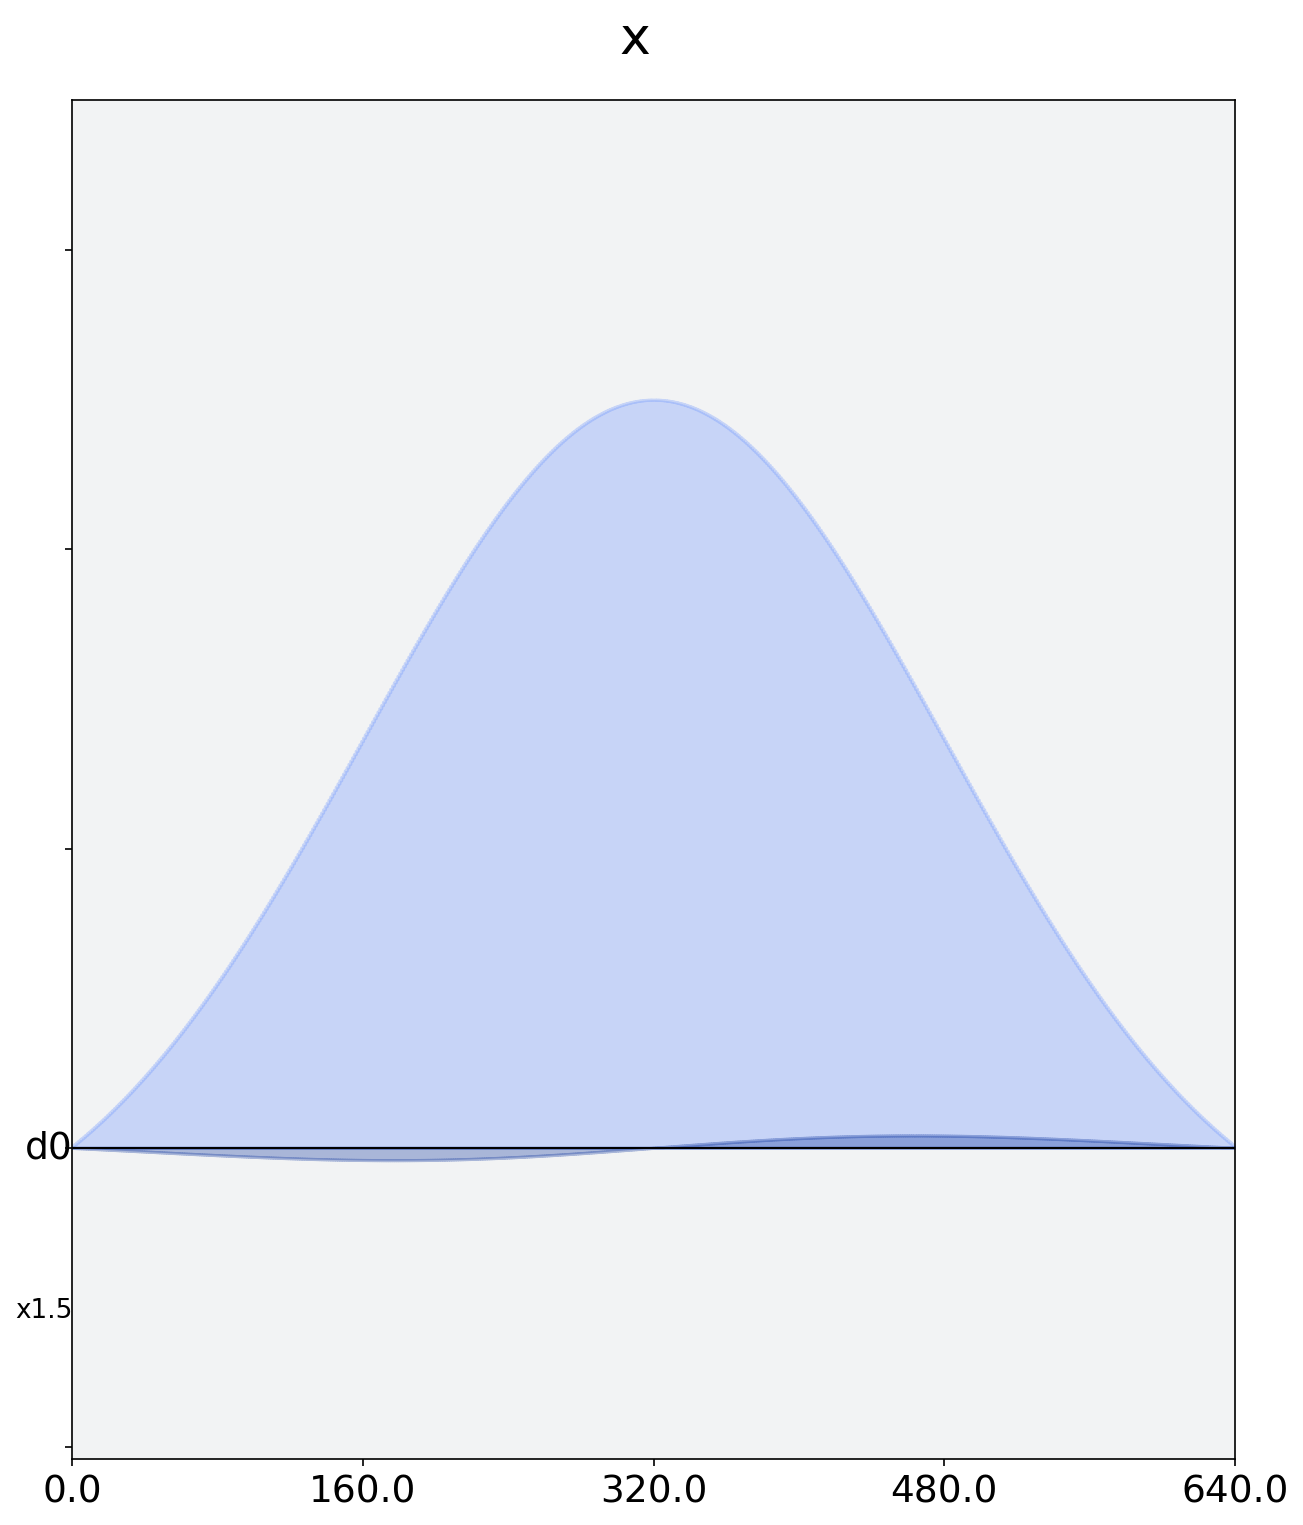

In [3]:
x_schedule.draw()

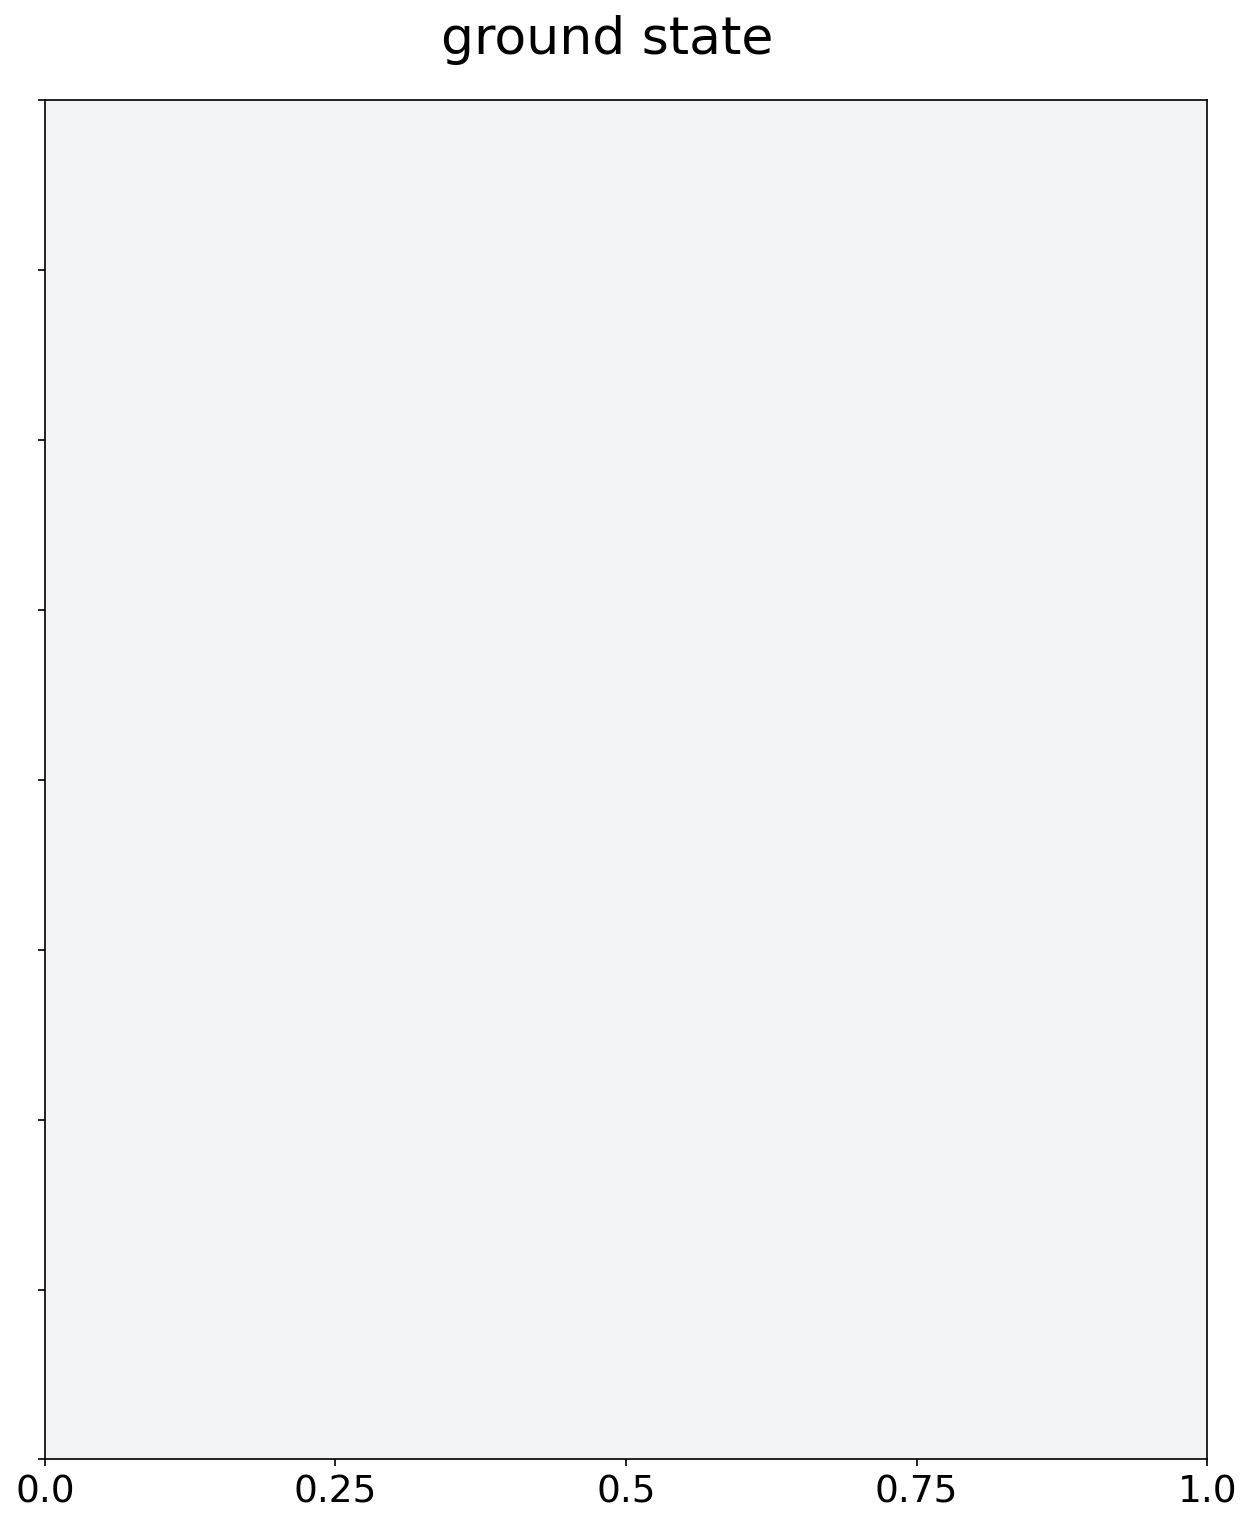

In [4]:
pulse.Schedule(name="ground state").draw()

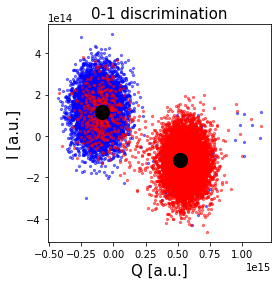

In [6]:
from matplotlib import pyplot as plt
import numpy as np
scale_factor = 0.7
gnd_results = result.get_memory(0)[:, qubit]*scale_factor
final_results = result.get_memory(1)[:, qubit]*scale_factor

plt.figure(figsize=[4,4])
# Plot all the results
# All results from the gnd_schedule are plotted in blue
plt.scatter(np.real(gnd_results), np.imag(gnd_results), 
                s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
# All results from the final_schedule are plotted in green
plt.scatter(np.real(final_results), np.imag(final_results), 
                s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')

# Plot a large dot for the average result of the 0 and 1 states.
mean_gnd = np.mean(gnd_results) # takes mean of both real and imaginary parts
mean_final = np.mean(final_results)
plt.scatter(np.real(mean_gnd), np.imag(mean_gnd), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_0_mean')
plt.scatter(np.real(mean_final), np.imag(mean_final), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_2_mean')

plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)
plt.title("0-1 discrimination", fontsize=15)
plt.show()

In [17]:
df = pd.DataFrame({'x_1':gnd_results.real, 'x_2':gnd_results.imag, 'y':[0]*8192})
final = pd.concat([df, pd.DataFrame({'x_1':final_results.real, 'x_2':final_results.imag, 'y':[1]*8192})])
final = final.sample(frac=1)
final.to_csv('datos.csv', index=False)
final

,x_1,x_2,y
6595,-1.851357e+14,3.565394e+13,0
6165,5.715585e+14,-8.484241e+13,1
5537,5.175931e+14,-1.231538e+14,1
7158,5.966117e+14,-1.778714e+14,1
3793,4.207345e+14,-1.175593e+14,1
...,...,...,...
3928,7.025930e+14,-1.572575e+14,0
6503,-8.740727e+13,7.636715e+13,0
2245,4.867707e+14,-1.507269e+14,1
7053,6.819048e+14,-1.245187e+14,1


In [18]:
read = pd.read_csv('datos.csv')

In [19]:
read

,x_1,x_2,y
0,-1.851357e+14,3.565394e+13,0
1,5.715585e+14,-8.484241e+13,1
2,5.175931e+14,-1.231538e+14,1
3,5.966117e+14,-1.778714e+14,1
4,4.207345e+14,-1.175593e+14,1
...,...,...,...
16379,7.025930e+14,-1.572575e+14,0
16380,-8.740727e+13,7.636715e+13,0
16381,4.867707e+14,-1.507269e+14,1
16382,6.819048e+14,-1.245187e+14,1


In [3]:
lol = pd.DataFrame([{'0': 516, '1': 7676}, {'0': 528, '1': 7664}, {'0': 540, '1': 7652}, {'0': 573, '1': 7619}, {'0': 529, '1': 7663}, {'0': 514, '1': 7678}, {'0': 516, '1': 7676}, {'0': 517, '1': 7675}, {'0': 528, '1': 7664}, {'0': 533, '1': 7659}, {'0': 548, '1': 7644}, {'0': 571, '1': 7621}, {'0': 515, '1': 7677}, {'0': 550, '1': 7642}, {'0': 501, '1': 7691}, {'0': 525, '1': 7667}, {'0': 543, '1': 7649}, {'0': 508, '1': 7684}, {'0': 541, '1': 7651}, {'0': 535, '1': 7657}, {'0': 566, '1': 7626}])

In [4]:
lol

,0,1
0,516,7676
1,528,7664
2,540,7652
3,573,7619
4,529,7663
5,514,7678
6,516,7676
7,517,7675
8,528,7664
9,533,7659
